# Get boxes in CONUS and South America
jjhenao May 2025 @ digital-earths-global-hackathon

In [18]:
# to be cleaned up
import healpix as hp
import numpy as np
import xarray as xr
import intake
import zarr
import easygems.healpix as egh
from easygems.healpix import attach_coords


import dask.array as da
import glob
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [4]:
current_location = "NCAR"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [107]:

dummy_ds = cat["scream2D_hrly"](zoom=8).to_dask() 
dummy_ds = attach_coords(dummy_ds)
dummy_ds

<xarray.Dataset> Size: 60GB
Dimensions:   (time: 9457, cell: 786432)
Coordinates:
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    lat       (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon       (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
    crs       int64 8B 0
  * cell      (cell) int64 6MB 0 1 2 3 4 ... 786427 786428 786429 786430 786431
Data variables:
    pr        (time, cell) float32 30GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 30GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ELEV      (cell) float32 3MB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 3MB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

<Figure size 640x480 with 0 Axes>

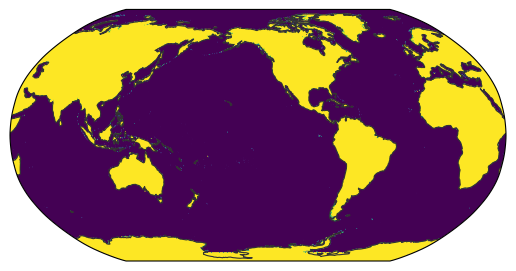

In [108]:
egh.healpix_show(dummy_ds["LANDFRAC"]);


In [16]:
# Subset data for SA and CONUS domains
us_lat_min = 20
us_lat_max = 55
us_lon_min = 220
us_lon_max = 304

In [89]:
#lon converter (just for me)
lon=-68
lon_360 = (lon + 360) % 360
print(lon_360)

292


In [85]:
### masks for selected regions

#based on https://easy.gems.dkrz.de/Processing/healpix/Land_sea_mask.html
def land(ds):
    return ds.LANDFRAC == 1

def ocean(ds):
    return ds.LANDFRAC == 0

def amazon(ds):
    return (ds.lat >= -10) & (ds.lat <= 3) & (ds.lon >= 292) & (ds.lon <= 310) & land(ds)

def colombia(ds):
    return (ds.lat >= -2) & (ds.lat <= 13) & (ds.lon >= 280) & (ds.lon <= 300) & land(ds)

def argent(ds):
    return (ds.lat >= -35) & (ds.lat <= -18) & (ds.lon >= 293) & (ds.lon <= 320) & land(ds)

def western(ds):
    return (ds.lat >= 32) & (ds.lat <= 48) & (ds.lon >= 235) & (ds.lon <= 255) & land(ds)

def central(ds):
    return (ds.lat >= 30) & (ds.lat <= 48) & (ds.lon >= 256) & (ds.lon <= 280) & land(ds)

In [116]:
cen_land = dummy_ds['pr'].where(central(dummy_ds).compute(),drop=True).isel(time=10)
wes_land = dummy_ds['pr'].where(western(dummy_ds).compute(),drop=True).isel(time=10)
col_land = dummy_ds['pr'].where(colombia(dummy_ds).compute(),drop=True).isel(time=10)
arg_land = dummy_ds['pr'].where(argent(dummy_ds).compute(),drop=True).isel(time=10)
ama_land = dummy_ds['pr'].where(amazon(dummy_ds).compute(),drop=True).isel(time=10)

In [127]:

cell_regions = {
    "central_us": cen_land.cell.values,
    "western_us": wes_land.cell.values,
    "northern_sa": col_land.cell.values,
    "amazon": ama_land.cell.values,
    "argentina": arg_land.cell.values,
}
cell_regions["central_us"]


import pickle

dir='/glade/derecho/scratch/jhenao/'

with open(dir+"region_healpix_cells_zoom8.pkl", "wb") as f:
    pickle.dump(cell_regions, f)
#dummy_ds['pr'].sel(cell=cen_land.cell.values)

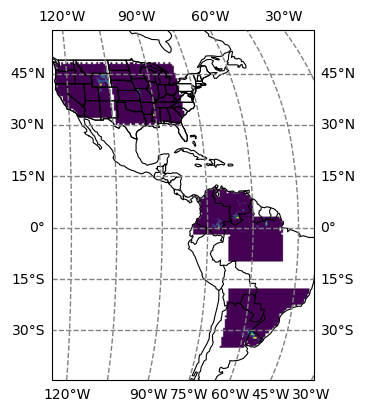

In [117]:
lon_min=-125
lon_max=-40
lat_min=-36
lat_max=50

projection = ccrs.Robinson(central_longitude=-135.5808361)

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)


ax.set_global()
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)
egh.healpix_show(col_land, cmap='viridis')
egh.healpix_show(arg_land, cmap='viridis')
egh.healpix_show(ama_land, cmap='viridis')
egh.healpix_show(wes_land, cmap='viridis')
egh.healpix_show(cen_land, cmap='viridis')
ax.set_extent([lon_min, lon_max, lat_min, lat_max]) 
# Add gridlines with latitude and longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--')
gl.xlocator = plt.MaxNLocator(integer=True)
gl.ylocator = plt.MaxNLocator(integer=True)

plt.show()
